# **MIMIC 3 Download using WFDB Python Package**

---



**Install WFDB Package** \
library contains functions to download data from physionet.


In [ ]:
pip install wfdb

In [ ]:
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import shutil
import posixpath
import pandas as pd
import requests
import wfdb
from wfdb.io import download
import matplotlib.pyplot as plt
from scipy.signal import find_peaks,welch
from scipy.stats import entropy

**rdrecord function** \

Read a WFDB record using the 'rdrecord' function into a wfdb.Record object.

Plot the signals, and show the data.

The file '3000063_0006' hosted on PhysioNet https://physionet.org/content/mimic3wdb/30/3000063/.

In [ ]:
record = wfdb.rdrecord('3000063_0006', pn_dir='mimic3wdb/30/3000063/')
wfdb.plot_wfdb(record=record, title='Record 3000063_0006 from PhysioNet mimic3wdb') 
display(record.__dict__)
record = wfdb.rdrecord('3000063n', pn_dir='mimic3wdb/30/3000063/', channel_names=['ABP SYS','ABP DIAS','ABP MEAN',])
wfdb.plot_wfdb(record=record, title='Record 3000063n from PhysioNet mimic3wdb') 
display(record.__dict__)

**rdsamp function** \
Read certain channels and sections of the WFDB record using the simplified 'rdsamp' function
which returns a numpy array and a dictionary. Show the data.
 
742015 samples = 1 hour, 38 minutes, and 56 seconds, at 125 samples per second. 

In [ ]:
signals, fields = wfdb.rdsamp('3000063_0006', pn_dir='mimic3wdb/30/3000063/', channel_names=['PLETH','ABP'])
numeric_signals, numeric_fields = wfdb.rdsamp('3000063n', pn_dir='mimic3wdb/30/3000063/', channel_names=['ABP SYS','ABP DIAS','ABP MEAN'])
signals_df = pd.DataFrame(signals)
fields = pd.Series(fields)
print(signals_df)
print(fields)
numeric_signals_df = pd.DataFrame(numeric_signals)
numeric_fields = pd.Series(numeric_fields)
print(numeric_signals_df)
print(numeric_fields)

Filter nan values.

In [ ]:
filtered_array_indices = {}
filtered_array = {} 
for i,field in enumerate(fields['sig_name']):
  filtered_array_indices[field] = np.where(np.isnan(signals[:, i]) == False)
  filtered_array[field] = signals[filtered_array_indices[field], i]
  print(filtered_array_indices[field])
  
display("indices:", filtered_array_indices)
display("filtered data:", filtered_array)

**Header file** \
contain data on the signal. used to download only relevant data.

In [ ]:
record = wfdb.rdheader('3000060_0001', pn_dir='mimic3wdb/30/3000060/', rd_segments=True)
display(record.__dict__)
ppg_signals, ppg_fields = wfdb.rdsamp('3000060_0002', pn_dir='mimic3wdb/30/3000060/', channel_names=['PLETH'])

**Download Full Data** \
Not recommended - take more then a month.

In [ ]:
# Make a temporary download directory in your current working directory
cwd = os.getcwd()
dl_dir = os.path.join(cwd, 'tmp_dl_dir')

# Download all the WFDB content
# wfdb.dl_database('mimic3wdb/31/3141595', dl_dir=dl_dir)

# Display the downloaded content in the folder
# display(os.listdir(dl_dir))

# Cleanup: delete the downloaded directory
# shutil.rmtree(dl_dir)

**File List to Download** \
Make a list of file names to download.

In [ ]:
db_dir = 'mimic3wdb'
# Full url PhysioNet database
if '/' in db_dir:
    dir_list = db_dir.split('/')
    db_dir = posixpath.join(dir_list[0], wfdb.io.record.get_version(dir_list[0]), *dir_list[1:])
else:
    db_dir = posixpath.join(db_dir,  wfdb.io.record.get_version(db_dir))
db_url = posixpath.join(download.PN_CONTENT_URL, db_dir) + '/'
# Check if the database is valid
r = requests.get(db_url)
r.raise_for_status()
# Get the list of records
record_list = download.get_record_list(db_dir)

print(f'Record list is: {record_list}')

all_files = []
nested_records = []
record_list = ['30/3000063/']

for rec in record_list:
  # Check out whether each record is in MIT or EDF format
  if rec.endswith('.edf'):
      all_files.append(rec)
  else:
      # May be pointing to directory
      if rec.endswith(os.sep):
          nested_records += [posixpath.join(rec, sr) for sr in download.get_record_list(posixpath.join(db_dir, rec))]
      else:
          nested_records.append(rec)

print(f'Nested record list is: {nested_records}')

**Download Filtered Data** \
Go through all the headers in this directory and download just samples with ABP and PLETH signal.

In [ ]:
filtered_records_list = []  
for rec in nested_records:
  # If MIT format, have to figure out all associated files
  all_files.append(rec+'.hea')
  dir_name, base_rec_name = os.path.split(rec)
  rec_header = wfdb.rdheader(base_rec_name, pn_dir=posixpath.join(db_dir, dir_name))
    
  if rec_header.sig_name and 'PLETH' in rec_header.sig_name and 'ABP' in rec_header.sig_name:
    record = wfdb.rdrecord(rec_header.record_name, pn_dir=posixpath.join(db_dir, dir_name), channel_names=['PLETH','ABP'])
    filtered_records_list.append((record, dir_name))
    wfdb.plot_wfdb(record=record, title=f'Record {record.record_name} from PhysioNet mimic3wdb')


**Save Data** \
save class record in its original directory hierarchy.

In [ ]:
record1, dir_name1 = filtered_records_list[0]
record2, dir_name2 = filtered_records_list[1]

import pickle

#save it
os.makedirs(posixpath.join(db_dir, dir_name1), exist_ok=True)
os.makedirs(posixpath.join(db_dir, dir_name2), exist_ok=True)

with open(f'{posixpath.join(db_dir, dir_name1, record1.record_name)}', 'wb') as file:
    pickle.dump(record1, file)

with open(f'{posixpath.join(db_dir, dir_name2, record2.record_name)}', 'wb') as file:
    pickle.dump(record2, file)

**Load Data** \
load class record.

In [ ]:
with open(f'{posixpath.join(db_dir, dir_name1, record1.record_name)}', 'rb') as file:
    record = pickle.load(file)
  
display(record.__dict__)
print(pd.DataFrame(record.p_signal))

import os

# traverse root directory, and list directories as dirs and files as files
for root, dirs, files in os.walk(db_dir):
    path = root.split(os.sep)
    print((len(path) - 1) * '---', os.path.basename(root))
    for file in files:
        print(len(path) * '---', file)

**Sample Blood Presure** \
sample the ABP signal to get sistolic and diastolic blood presure.

In [ ]:
abp_index = record.sig_name.index('ABP')
ppg_index = record.sig_name.index('PLETH')
abp_signal = np.array(record.p_signal[:, abp_index])
ppg_signal = np.array(record.p_signal[:, ppg_index])
abp_fs = record.fs
start_point = 200000
window_in_sec = 5
end_point = start_point + (window_in_sec*abp_fs)
cut_abp_signal = abp_signal[start_point:end_point]

x = np.linspace(0, window_in_sec, len(cut_abp_signal))
plt.title('5 Seconds Window ABP signal')
plt.plot(x, cut_abp_signal)
plt.ylabel('ABP [mmHg]')
plt.xlabel('Time [sec]')

**Detect Systolic and Diastolic Blood Presure** \


**Systolic Blood Presure**

In [ ]:
max_peaks, _ = find_peaks(cut_abp_signal)
sys_peaks = max_peaks[cut_abp_signal[max_peaks] >= np.mean(cut_abp_signal[max_peaks])]
x = np.linspace(0, window_in_sec, len(cut_abp_signal))
plt.title('5 Seconds Window ABP signal')
plt.plot(x, cut_abp_signal)
plt.plot(sys_peaks/abp_fs, cut_abp_signal[sys_peaks], 'x')
plt.ylabel('ABP [mmHg]')
plt.xlabel('Time [sec]')

systolic_bp = np.mean(cut_abp_signal[sys_peaks])
print(f'systolic_bp: {systolic_bp}')

**Diastolic blood presure**

In [ ]:
min_peaks, _ = find_peaks(-cut_abp_signal)
dias_peaks = min_peaks[cut_abp_signal[min_peaks] <= np.mean(cut_abp_signal[min_peaks])]

x = np.linspace(0, window_in_sec, len(cut_abp_signal))
plt.title('5 Seconds Window ABP signal')
plt.plot(x, cut_abp_signal)
plt.plot(dias_peaks/abp_fs, cut_abp_signal[dias_peaks], "x")
plt.ylabel('ABP [mmHg]')
plt.xlabel('Time [sec]')
plt.show()

diastolic_bp = np.mean(cut_abp_signal[dias_peaks])
print(f'diastolic_bp: {diastolic_bp}')

**Blood pressure detection**

In [ ]:
def bp_detection(signal):

  max_peaks, _ = find_peaks(signal)
  sys_peaks = max_peaks[signal[max_peaks] >= np.mean(signal[max_peaks])]
  min_peaks, _ = find_peaks(-signal)
  dias_peaks = min_peaks[signal[min_peaks] <= np.mean(signal[min_peaks])]
  
  systolic_bp = np.mean(signal[sys_peaks])
  diastolic_bp = np.mean(signal[dias_peaks])

  return systolic_bp, diastolic_bp

**Windows signal** \
Seperate the signal to windows of 30 seconds \
Overlap 50% of the previous window

In [ ]:
bp_windows = []
ppg_windows = []
abp_fs = record.fs
start_point = 0
window_in_sec = 30
end_point = start_point + (window_in_sec*abp_fs)
window_overlap = window_in_sec / 2
new_samples_per_step = np.int(window_overlap * abp_fs)

while end_point < record.sig_len:
  bp_windows.append(abp_signal[start_point:end_point])
  ppg_windows.append(ppg_signal[start_point:end_point])
  start_point += new_samples_per_step
  end_point += new_samples_per_step

print(pd.DataFrame(bp_windows))
print(pd.DataFrame(ppg_windows))

**Filter Blood Pressure**

In [ ]:
filtered_bp = []
for i,win in enumerate(bp_windows):
  
  if np.count_nonzero(np.isnan(win)):
    continue

  sys, dias = bp_detection(win)
  max_peak = np.max(win)
  min_peak = np.min(win)

  if sys > 165 or sys < 75 or dias < 40 or dias > 85 or min_peak < 40 or max_peak > 185:
    continue

  filtered_bp.append(win)

bp_windows = np.array(bp_windows)
print(pd.DataFrame(filtered_bp))

In [ ]:
bp_windows = np.concatenate(bp_windows)
filtered_bp = np.concatenate(filtered_bp)

samples_in_hour = abp_fs*3600
x1 = np.linspace(0, (len(bp_windows)/samples_in_hour), len(bp_windows))
x2 = np.linspace(0, (len(filtered_bp)/samples_in_hour), len(filtered_bp))
fig, axs = plt.subplots(2)
fig.suptitle('ABP signal')
axs[0].plot(x1, bp_windows)
axs[1].plot(x2, filtered_bp)
axs[0].set(xlabel='Time [hours]', ylabel='ABP [mmHg]')
axs[1].set(xlabel='Time [hours]', ylabel='ABP [mmHg]')


**Cross Correlation** \
Use cross correletion to check the quality of the signal

In [ ]:
ppg_norm = []
filtered_ppg = []

for i,ppg_window in enumerate(ppg_windows):

  ppg_centered = ppg_window - np.mean(ppg_window)
  ppg_corr = np.correlate(ppg_centered, ppg_centered, 'full')
  ppg_corr_norm = ppg_corr/ppg_corr[3750]
  ppg_corr_norm = ppg_corr_norm[len(ppg_window):]
  
  e_ppg_centered = np.sum(np.power(ppg_centered,2))
  e_ppg_corr_norm = np.sum(np.power(ppg_corr_norm,2))

  if not np.count_nonzero(np.isnan(ppg_window)):
    ppg_norm.append(e_ppg_corr_norm)
    filtered_ppg.append(ppg_window)

filtered_ppg = np.array(filtered_ppg)
ppg_norm = np.array(ppg_norm)
max_index = np.argmax(ppg_norm)
min_index = np.argmin(ppg_norm)

good_signals = filtered_ppg[np.where(ppg_norm > 375)]
bad_signals = filtered_ppg[ppg_norm <= 375]

mid_good_norm = np.median(ppg_norm[ppg_norm > 375])
mid_bad_norm = np.median(ppg_norm[ppg_norm <= 375])
mid_good_signal_index = np.where(ppg_norm == mid_good_norm)
mid_bad_signal_index = np.where(ppg_norm == mid_bad_norm)
mid_good_signal_index = np.concatenate(np.array(mid_good_signal_index))[0]
mid_bad_signal_index = np.concatenate(np.array(mid_bad_signal_index))[0]

low_good_norm = np.min(ppg_norm[ppg_norm > 375])
high_bad_norm = np.max(ppg_norm[ppg_norm <= 375])
low_good_signal_index = np.where(ppg_norm == low_good_norm)
high_bad_signal_index = np.where(ppg_norm == high_bad_norm)
low_good_signal_index = np.concatenate(np.array(low_good_signal_index))[0]
high_bad_signal_index = np.concatenate(np.array(high_bad_signal_index))[0]

x = np.linspace(0, window_in_sec, len(filtered_ppg[max_index]))
fig, axs = plt.subplots(3)
fig.suptitle('Good PPG signal')
axs[0].plot(x, filtered_ppg[max_index])
axs[1].plot(x, filtered_ppg[mid_good_signal_index])
axs[2].plot(x, filtered_ppg[low_good_signal_index])
axs[0].set(xlabel='Time [sec]', ylabel='PLETH [NU]')
axs[1].set(xlabel='Time [sec]', ylabel='PLETH [NU]')
axs[2].set(xlabel='Time [sec]', ylabel='PLETH [NU]')

fig, axs = plt.subplots(3)
fig.suptitle('Bad PPG signal')
axs[2].plot(x, filtered_ppg[min_index])
axs[1].plot(x, filtered_ppg[mid_bad_signal_index])
axs[0].plot(x, filtered_ppg[high_bad_signal_index])
axs[0].set(xlabel='Time [sec]', ylabel='PLETH [NU]')
axs[1].set(xlabel='Time [sec]', ylabel='PLETH [NU]')
axs[2].set(xlabel='Time [sec]', ylabel='PLETH [NU]')

## **Signal Quality Indices (SQI)** 
#### **[Optimal Signal Quality Index for Photoplethysmogram Signals](https://technionmail-my.sharepoint.com/personal/tuvalgelvan_campus_technion_ac_il/_layouts/15/onedrive.aspx?listurl=%2Fpersonal%2Fmyair%5Ftechnion%5Fac%5Fil%2FDocuments&remoteItem=%7B%22mp%22%3A%7B%22webAbsoluteUrl%22%3A%22https%3A%2F%2Ftechnionmail%2Dmy%2Esharepoint%2Ecom%2Fpersonal%2Ftuvalgelvan%5Fcampus%5Ftechnion%5Fac%5Fil%22%2C%22listFullUrl%22%3A%22https%3A%2F%2Ftechnionmail%2Dmy%2Esharepoint%2Ecom%2Fpersonal%2Ftuvalgelvan%5Fcampus%5Ftechnion%5Fac%5Fil%2FDocuments%22%2C%22rootFolder%22%3A%22%2Fpersonal%2Ftuvalgelvan%5Fcampus%5Ftechnion%5Fac%5Fil%2FDocuments%2Fproject%20%2D%20Blood%20Pressure%20Estimation%20with%20a%20Smartwatch%22%7D%2C%22rsi%22%3A%7B%22listFullUrl%22%3A%22https%3A%2F%2Ftechnionmail%2Dmy%2Esharepoint%2Ecom%2Fpersonal%2Fmyair%5Ftechnion%5Fac%5Fil%2FDocuments%22%2C%22rootFolder%22%3A%22%2Fpersonal%2Fmyair%5Ftechnion%5Fac%5Fil%2FDocuments%2Fsemesters%2F2020B%2Fproject%20%2D%20Blood%20Pressure%20Estimation%20with%20a%20Smartwatch%2Fpapers%2Fppg%20quality%22%2C%22webAbsoluteUrl%22%3A%22https%3A%2F%2Ftechnionmail%2Dmy%2Esharepoint%2Ecom%2Fpersonal%2Fmyair%5Ftechnion%5Fac%5Fil%22%7D%7D&id=%2Fpersonal%2Fmyair%5Ftechnion%5Fac%5Fil%2FDocuments%2Fsemesters%2F2020B%2Fproject%20%2D%20Blood%20Pressure%20Estimation%20with%20a%20Smartwatch%2Fpapers%2Fppg%20quality%2F2016%20%2D%20Optimal%20Signal%20Quality%20Index%20for%20Photoplethysmogram%20Signals%2Epdf&parent=%2Fpersonal%2Fmyair%5Ftechnion%5Fac%5Fil%2FDocuments%2Fsemesters%2F2020B%2Fproject%20%2D%20Blood%20Pressure%20Estimation%20with%20a%20Smartwatch%2Fpapers%2Fppg%20quality)**
Perfusion ($P_{SQI}$) - the difference of the amount of light
absorbed through the pulse of when light is transmitted through the finger. ( gold standard) \
\
$P_{SQI} = [(y_{max} − y_{min})/|x_{mean}|] × 100$ \

---
Skeweness ($S_{SQI}$) - measure of the symmetry (or the lack of it)
of a probability distribution. \
\
$S_{SQI} = 1/N ∑_{i=1}^{N}[x_i − \hat{µ}_x/σ]^3$ \

---
Kurtosis ($K_{SQI}$) - measure used to describe the distribution of observed
data around the mean. \
\
$K_{SQI} = 1/N ∑_{i=1}^{N}[x_i − \hat{µ}_x/σ]^4$ \

---
Entropy ($E_{SQI}$) - Entropy quantifies how much the probability density function (PDF) of the signal differs from a uniform distribution and thus provides a quantitative measure of the uncertainty present in the signal. \
\
$E_{SQI} = −∑_{n=1}^{N}x[n]^2log_e(x[n]^2)$  \

---
Zero crossing rate ($Z_{SQI}$) - s the rate of sign-changes in the processed signal, that is, the rate at which the signal changes from positive to negative or back. \
\
$Z_{SQI} =  1/N ∑_{i=1}^{N}I\{y<0\}$ \

---
Signal-to-noise ratio ($N_{SQI}$) -  measure used in science and engineering that compares the level of a desired signal to the level of background noise. \
\
$N_{SQI} =  \sigma^2_{signal}/\sigma^2_{noise}$ \

---
Matching of multiple systolic wave detection algorithms ($M_{SQI}$) - Because different PPG algorithms are sensitive to different types of noise, the comparison of how accurately multiple PPG systolic wave detectors isolate each event (such as a beat or noise artifact) provides one estimate of the level of noise in the PPG. The reason for selecting Bing’s and Billauer’s algorithms is that both are easy to implement and each algorithm approaches the PPG signal from different perspectives. \
\
$M_{SQI} = (SBing ∩ SBillauer)/SBing$ \

---
Relative power ($R_{SQI}$) -  The frequency domain was explored to assess the PPG signal quality, a different perspective from the time domain features discussed above. Because most of the energy of the systolic and diastolic waves is concentrated within the 1–2.25 Hz frequency
band, the ratio of the power spectral density (PSD) in this band compared to the PSD in the overall signal 0–8 Hz provides a measure of the signal quality. \
\
$R_{SQI} = ∑_{f=1}^{2.25}PSD/∑_{f=0}^{8}PSD$ \
\
(calculate PSD with welch method) \

---





In [ ]:
def calculate_p_sqi(win, y):
  x_mean = np.mean(win)
  p_sqi = ((np.max(win) - np.min(win))/x_mean)*100
  return p_sqi

def calculate_s_sqi(win):
  mu = np.mean(win)
  sigma = np.std(win)
  N = len(win)
  s_sqi = (np.sum([(x_i - mu/sigma)**3 for x_i in win]))/N
  return s_sqi

def calculate_k_sqi(win):
  mu = np.mean(win)
  sigma = np.std(win)
  N = len(win)
  k_sqi = (np.sum([(x_i - mu/sigma)**4 for x_i in win]))/N
  return k_sqi

def calculate_e_sqi(win):
  x_squared = (win)**2
  e_sqi = entropy(x_squared)
  return e_sqi

def calculate_z_sqi(y):
  z_sqi = np.sum(y[y < 0]) / len(y)
  return z_sqi

def calculate_r_sqi(win):
  frequencies, psd = welch(win, record.fs)
  for i,f in enumerate(frequencies):
    if f < 2.25 and f > 1:
      sum1 += psd[i]
    if f > 0 and f < 8:
      sum2 += psd[i]
  r_sqi = sum1/sum2
  return r_sqi

#add m_sqi, n_sqi

**$P_{SQI}$** \
example of $P_{SQI}$ window calculation

In [ ]:
p_sqi_list = []
win_list = []
for i,win in enumerate(ppg_windows):
  
  y = win - np.mean(win)

  if not np.count_nonzero(np.isnan(win)):
    p_sqi = calculate_p_sqi(win,y)
    p_sqi_list.append(p_sqi)
    win_list.append(win)
  
print(p_sqi_list)
max_index = np.argmax(p_sqi_list)
min_index = np.argmin(p_sqi_list)
print(p_sqi_list[max_index], p_sqi_list[min_index])

x = np.linspace(0, window_in_sec, len(win_list[max_index]))
fig, axs = plt.subplots(2)
fig.suptitle('$P_{sqi}$')
axs[0].plot(x, win_list[max_index])
axs[1].plot(x, win_list[min_index])
axs[0].set(xlabel='Time [sec]', ylabel='PLETH [NU]')
axs[1].set(xlabel='Time [sec]', ylabel='PLETH [NU]')

**$S_{SQI}$** \
example of $S_{SQI}$ window calculation

In [ ]:
s_sqi_list = []
win_list = []
for i,win in enumerate(ppg_windows):
  if not np.count_nonzero(np.isnan(win)):
    s_sqi = calculate_s_sqi(win)
    s_sqi_list.append(s_sqi)
    win_list.append(win)
  
print(s_sqi_list)
max_index = np.argmax(s_sqi_list)
min_index = np.argmin(s_sqi_list)
print(s_sqi_list[max_index], s_sqi_list[min_index])

x = np.linspace(0, window_in_sec, len(win_list[max_index]))
fig, axs = plt.subplots(2)
fig.suptitle('$S_{sqi}$')
axs[0].plot(x, win_list[max_index])
axs[1].plot(x, win_list[min_index])
axs[0].set(xlabel='Time [sec]', ylabel='PLETH [NU]')
axs[1].set(xlabel='Time [sec]', ylabel='PLETH [NU]')

**$E_{SQI}$** \
example of $E_{SQI}$ window calculation

In [ ]:
e_sqi_list = []
win_list = []
for i,win in enumerate(ppg_windows):
  if not np.count_nonzero(np.isnan(win)):
    e_sqi = calculate_e_sqi(win)
    e_sqi_list.append(e_sqi)
    win_list.append(win)
  
print(e_sqi_list)
max_index = np.argmax(e_sqi_list)
min_index = np.argmin(e_sqi_list)
print(e_sqi_list[max_index], e_sqi_list[min_index])

x = np.linspace(0, window_in_sec, len(win_list[max_index]))
fig, axs = plt.subplots(2)
fig.suptitle('$E_{sqi}$')
axs[0].plot(x, win_list[max_index])
axs[1].plot(x, win_list[min_index])
axs[0].set(xlabel='Time [sec]', ylabel='PLETH [NU]')
axs[1].set(xlabel='Time [sec]', ylabel='PLETH [NU]')


#### **Signal-Quality Indices for the Electrocardiogram and Photoplethysmogram: Derivation and Applications to Wireless Monitoring**

1) Rule 1: The HR extrapolated from the 10-s sample must
be between 40 and 180 beats per minute (bpm). (Though
it is theoretically possible to have HRs outside of these
values, this is the physiologically probable range of HR
for the adult population likely to use wearable sensors.)
2) Rule 2: The maximum acceptable gap between successive
R-peaks/PPG pulse-peaks is 3 s. (This rule ensures no
more than one beat is missed.)
3) Rule 3: The ratio of the maximum beat-to-beat interval
to the minimum beat-to-beat interval within the sample
should be less than 2.2. (This is a conservative limit since
we would not expect the HR to change by more than 10%
in a 10-s sample. We use a limit of 2.2 to allow for a single
missed beat.) \

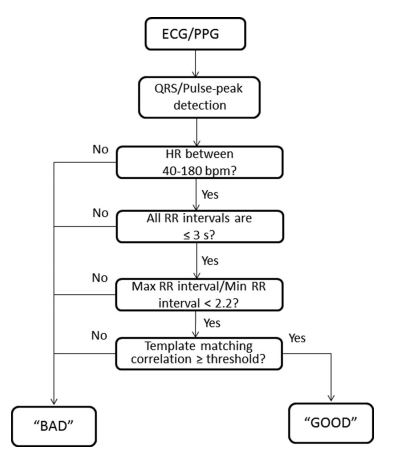


**Make sample class from windows**

In [ ]:
import pickle
import posixpath
import numpy as np
import pandas as pd
import os
import wfdb
import copy
import os
import shutil
import posixpath
import matplotlib
import pandas as pd
import requests
import wfdb
from wfdb.io import download
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, welch
from scipy.stats import entropy
import tqdm
import time
from scipy import signal
from scipy.fft import fftshift
from multiprocessing import Pool

squered_magnitude_threshold = 200
window_in_sec = 30
frequency_end = 12
frequency_start = 0
stft_window_size = 750


class Sample:

    def __init__(self, window, systolic_bp, diastolic_bp, bp_index, ppg_index):
        self.window = window
        self.systolic_bp = systolic_bp
        self.diastolic_bp = diastolic_bp
        self.bp_index = bp_index
        self.ppg_index = ppg_index
        self.squared_magnitude_ppg = None
        self.window_number = None


def load_records(records_path):
    records = []
    # traverse root directory, and list directories as dirs and files as files
    print("loading records...")
    for root, dirs, files in tqdm.tqdm(os.walk(records_path)):
        path = root.split(os.sep)
        # print(root)
        # print((len(path) - 1) * '---', os.path.basename(root))
        for file in files:
            # print(len(path) * '---', file)
            with open(f'{posixpath.join(root, file)}', 'rb') as f:
                record = pickle.load(f)
                records.append(record)
    print("loading records done")
    return records


def print_records(records):
    print("The records are:")
    for record in records:
        print(record.record_name)

    print(f"Number of records: {len(records)}")


# remove files without relevant PPG and ABP
def remove_unrelevant_records(records):
    filtered_records = []

    # remove file names without relevant data
    for record in records:
        if record.record_name[-1] != 'n':
            filtered_records.append(record)

    return filtered_records


def record_to_windows(record):
    start_point = 0
    fs = record.fs
    end_point = start_point + (window_in_sec * fs)
    window_overlap = window_in_sec / 2
    new_samples_per_step = np.int(window_overlap * fs)
    record_windows = []

    while end_point < record.sig_len:
        p_signal = record.p_signal[start_point:end_point]
        window = copy.copy(record)
        window.p_signal = p_signal
        window.sig_len = end_point - start_point
        start_point += new_samples_per_step
        end_point += new_samples_per_step
        record_windows.append(window)

    return record_windows


def records_to_windows(records):
    windows = []
    for record in records:
        record_windows = record_to_windows(record)
        windows.append(record_windows)

    windows = np.concatenate(windows)
    return windows


def print_window(window):
    window_in_sec = window.sig_len / window.fs
    x = np.linspace(0, window_in_sec, window.sig_len)

    fig, axs = plt.subplots(2)
    fig.suptitle('30 Seconds Window signal')
    axs[0].plot(x, window.p_signal[:, 0])
    axs[1].plot(x, window.p_signal[:, 1])
    axs[1].set(xlabel='Time [sec]', ylabel='ABP [mmHg]')
    axs[0].set(xlabel='Time [sec]', ylabel='PLETH [NU]')
    plt.show()


def bp_detection(signal):
    max_peaks, _ = find_peaks(signal)
    min_peaks, _ = find_peaks(-signal)
    systolic_bp, diastolic_bp = 0, 0

    if len(max_peaks) != 0:
        sys_peaks = max_peaks[signal[max_peaks] >= np.mean(signal[max_peaks])]
        if len(sys_peaks) != 0:
            systolic_bp = np.mean(signal[sys_peaks])

    if len(min_peaks) != 0:
        dias_peaks = min_peaks[signal[min_peaks] <= np.mean(signal[min_peaks])]
        if len(dias_peaks) != 0:
            diastolic_bp = np.mean(signal[dias_peaks])

    return systolic_bp, diastolic_bp


def sample_bp_valid(sample):
    # remove windows that not in valid range
    if sample.systolic_bp > 185 or sample.systolic_bp < 55 or sample.diastolic_bp < 30 or sample.diastolic_bp > 120:
        return False

    return True


def bp_filter(windows):
    samples = []
    bp_index = windows[0].sig_name.index('ABP')
    ppg_index = windows[0].sig_name.index('PLETH')
    for window in windows:
        if window_valid(window, bp_index, ppg_index):
            bp_signal = window.p_signal[:, bp_index]
            bp_signal = np.array(bp_signal)
            systolic_bp, diastolic_bp = bp_detection(bp_signal)
            sample = Sample(window, systolic_bp, diastolic_bp, bp_index, ppg_index)
            if sample_bp_valid(sample):
                samples.append(sample)

    return samples


def window_valid(window, bp_index, ppg_index):
    bp_signal = window.p_signal[:, bp_index]
    ppg_signal = window.p_signal[:, ppg_index]
    # remove windows with nan values
    if np.count_nonzero(np.isnan(ppg_signal)) or np.count_nonzero(np.isnan(bp_signal)):
        return False

    return True


def squared_magnitude_ppg_detection(ppg_signal):
    ppg_centered = ppg_signal - np.mean(ppg_signal)
    ppg_corr = np.correlate(ppg_centered, ppg_centered, 'full')
    if ppg_corr[3750] != 0:
        ppg_corr_norm = ppg_corr / ppg_corr[3750]
        ppg_corr_norm = ppg_corr_norm[len(ppg_signal):]
        squared_magnitude_ppg = np.sum(np.power(ppg_corr_norm, 2))
    else:
        squared_magnitude_ppg = 0

    return squared_magnitude_ppg


def ppg_filter(samples):
    filtered_samples = []
    for sample in samples:
        ppg_signal = sample.window.p_signal[:, sample.ppg_index]
        sample.squared_magnitude_ppg = squared_magnitude_ppg_detection(ppg_signal)
        if sample.squared_magnitude_ppg > squered_magnitude_threshold:
            filtered_samples.append(sample)

    return filtered_samples


def save_sample(sample):
    ppg_signal = sample.window.p_signal[:, sample.ppg_index]
    fs = sample.window.fs
    noverlap = 0.96 * stft_window_size
    plt.specgram(ppg_signal, Fs=fs, scale='dB', NFFT=stft_window_size, noverlap=noverlap)
    plt.axis(ymin=frequency_start, ymax=frequency_end)
    dir_path = f"Data/{sample.window.record_name}"
    if not os.path.isdir(dir_path):
        os.makedirs(dir_path)
    plt.savefig(f"Data/{sample.window.record_name}/"
                f"{sample.window.record_name}_{sample.window_number}_{sample.systolic_bp}_{sample.diastolic_bp}.png")
    plt.close()


def samples_to_spectograms(samples):
    print("saving images..")
    pool = Pool()
    for _ in tqdm.tqdm(pool.imap(func=save_sample, iterable=samples), total=len(samples)):
        pass

    print("images saving done")


def get_window_numbers(samples):
    window_number = 0
    last_record_name = samples[0].window.record_name
    for sample in samples:
        sample.window_number = window_number
        window_number += 1
        if last_record_name != sample.window.record_name:
            window_number = 0
        last_record_name = sample.window.record_name

    return samples


def main():
    records_path = 'mimic3wdb'
    # records_path = '../../../Test_data'
    records = load_records(records_path)
    # print_records(records)
    filtered_records = remove_unrelevant_records(records)
    # print_records(filtered_records)
    windows = records_to_windows(filtered_records)
    # print_window(windows[200])
    filtered_bp_samples = bp_filter(windows)
    # print_window(filtered_bp_samples[2].window)
    filtered_ppg_samples = ppg_filter(filtered_bp_samples)
    # print_window(filtered_ppg_samples[5].window)
    samples = get_window_numbers(filtered_ppg_samples)
    samples_to_spectograms(samples)
    print(
        f"Num Windows (30 sec): {len(windows)}, After bp filter: {len(filtered_bp_samples)}, After ppg filter: {len(filtered_ppg_samples)}")


if __name__ == "__main__":
    main()

**Load Data**

In [ ]:
import os
import posixpath

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import tqdm
from torch.autograd import Variable
from torchvision import datasets, models, transforms


class Data:

    def __init__(self, images_train, images_val, images_test, dias_bp_list_train, dias_bp_list_val,
               dias_bp_list_test,sys_bp_list_train, sys_bp_list_val, sys_bp_list_test):
        self.images_train = images_train
        self.images_val = images_val
        self.images_test = images_test
        self.dias_bp_train = dias_bp_list_train
        self.dias_bp_val = dias_bp_list_val
        self.dias_bp_test = dias_bp_list_test
        self.sys_bp_train = sys_bp_list_train
        self.sys_bp_val = sys_bp_list_val
        self.sys_bp_test = sys_bp_list_test


def load_data(data_path):
    # traverse root directory, and list directories as dirs and files as files
    print("loading images...")
    # data = Data()
    images_list = []
    sys_bp_list = []
    dias_bp_list = []
    for root, dirs, images in tqdm.tqdm(os.walk(data_path)):
        path = root.split(os.sep)
        for image_name in images:
            image = cv2.imread(posixpath.join(root, image_name))
            image = cv2.resize(image, (110, 110))
            # image = np.asarray(image)
            # normalized_image = (image - np.mean(image)) / np.std(image)
            # normalized_image = torch.tensor(normalized_image.T).view(1, 4, 640, 480)
            # normalized_image = normalized_image.to(device=device, dtype=torch.float)
            # normalized_image = Variable(normalized_image.cuda(device))
            name = image_name.split('_')
            # name example: 3000063_0025_1_124.32324334151441_60.60244138052165.png
            systolic_bp = np.float64(name[3])
            diastolic_bp = np.float64(name[4][:-4])
            # data.add_image(image, image_name, systolic_bp, diastolic_bp)
            images_list.append(image)
            sys_bp_list.append(systolic_bp)
            dias_bp_list.append(diastolic_bp)

    print("loading images done")
    images_list = np.asarray(images_list)
    sys_bp_list = np.asarray(sys_bp_list)
    dias_bp_list = np.asarray(dias_bp_list)
    return images_list, sys_bp_list, dias_bp_list


def split_data(images_list, sys_bp_list, dias_bp_list):


    n_samples = images_list.shape[0]  # The total number of samples in the dataset

    # Generate a random generator with a fixed seed
    rand_gen = np.random.RandomState(0)

    # Generating a shuffled vector of indices
    indices = np.arange(n_samples)
    rand_gen.shuffle(indices)

    # Split the indices into 60% train / 20% validation / 20% test
    n_samples_train = int(n_samples * 0.6)
    n_samples_val = n_samples_train + int(n_samples * 0.2)
    train_indices = indices[:n_samples_train]
    val_indices = indices[n_samples_train:n_samples_val]
    test_indices = indices[n_samples_val:]

    # Extract the sub datasets from the full dataset using the calculated indices

    images_train = images_list[train_indices]
    dias_bp_list_train = dias_bp_list[train_indices]
    sys_bp_list_train = sys_bp_list[train_indices]
    images_val = images_list[val_indices]
    dias_bp_list_val = dias_bp_list[val_indices]
    sys_bp_list_val = sys_bp_list[val_indices]
    images_test = images_list[test_indices]
    dias_bp_list_test = dias_bp_list[test_indices]
    sys_bp_list_test = sys_bp_list[test_indices]

    data = Data(images_train, images_val, images_test, dias_bp_list_train,dias_bp_list_val,
               dias_bp_list_test,sys_bp_list_train, sys_bp_list_val, sys_bp_list_test)
    return data


def print_some_images(images):
    print('Number of images in the dataset: {}'.format(len(images)))
    print('Each images size is: {}'.format(images.shape[1:]))
    print('These are the first 4 images:')
    fig, ax_array = plt.subplots(2, 2)
    for i, ax in enumerate(ax_array.flat):
        ax.imshow(images[i], cmap='gray')
        ax.set_yticks([])
        ax.set_xticks([])
    plt.show()

def get_device():
    # load torch
    print("torch version:", torch.__version__)
    if torch.cuda.is_available():
        print("cuda version:", torch.version.cuda)
        device = torch.device('cuda:0')
        torch.cuda.empty_cache()
        print("run on GPU.")
    else:
        device = torch.device('cpu')
        print("no cuda GPU available")
        print("run on CPU")
    return device



data_path = 'Data'
# device = get_device()
images_list, sys_bp_list, dias_bp_list = load_data(data_path)
data = split_data(images_list, sys_bp_list, dias_bp_list)
print_some_images(data.images_train)

**ResNet18 Training**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms

## Set some default values of the the matplotlib plots
plt.rcParams['figure.figsize'] = (8.0, 8.0)  # Set default plot's sizes
plt.rcParams['axes.grid'] = True  # Show grid by default in figures

'''
Example for CNN module:
class CNN(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super(CNN, self).__init__()
        ## Defining the convolutional and fully connected layers with their parameters
        ## ===========================================================================
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.fc3 = torch.nn.Linear(in_features=256 * 2 * 2, out_features=256, bias=True)
        self.fc4 = torch.nn.Linear(in_features=256, out_features=10, bias=True)
    def forward(self, x):
        x = x[:, None, :, :]
        z = self.conv1(x)
        z = torch.nn.functional.relu(z)
        z = self.conv2(z)
        z = torch.nn.functional.relu(z)
        z = z.view(z.shape[0], -1)
        z = self.fc3(z)
        z = torch.nn.functional.relu(z)
        z = self.fc4(z)
        y = torch.nn.functional.log_softmax(z, dim=1)
        return y
'''


def train(model, learning_rate, n_epochs, train_loader, x_val, y_val, optimizer, criterion):
    ## Move validation set to the GPU
    x_val = x_val.cuda()
    y_val = y_val.cuda()

    ## Prepare lists to store intermediate obejectives
    train_objective_list = [np.inf]
    val_objective_list = [np.inf]

    ## Run for n_epochs
    for epoch in tqdm.tqdm(range(n_epochs)):
        ## Run over the batches
        for x, y in train_loader:  # forward
            outputs = torch.squeeze(model(x))
            # loss
            loss = criterion(outputs, y)
            ## Move batch to GPU
            x = x.cuda()
            y = y.cuda()

            # start training
            optimizer.zero_grad()
            # forward
            outputs = torch.squeeze(model(x))
            # loss
            loss = criterion(outputs, y)
            # backward
            loss.backward()
            optimizer.step()

        ## Evaluate the objective on the validation set
        with torch.no_grad():  ## This tell PyTorch not to calculate the gradients to save time
            train_objective_list.append(loss.item())
            # forward
            outputs = torch.squeeze(model(x))
            # loss
            loss = criterion(outputs, y)
            val_objective_list.append(loss.item())

    return train_objective_list, val_objective_list


def fine_tuning(model, optimizer, criterion):
    n_epochs = 20
    etas_list = (1e-1, 3e-2, 1e-2, 3e-3)

    fig, axes = plt.subplots(2, 2, figsize=(6, 6))
    for i_eta, eta in enumerate(etas_list):
        train_objective_list, val_objective_list = train(model, eta, n_epochs, train_loader,
                                                         torch.tensor(x_val).float(),
                                                         torch.tensor(y_val).long(),
                                                         optimizer,
                                                         criterion)

        ## Plot
        ax = axes.flat[i_eta]
        ax.plot(np.arange(len(train_objective_list)), train_objective_list, label='Train')
        ax.plot(np.arange(len(val_objective_list)), val_objective_list, label='Validation')
        ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
        ax.set_xlabel('Step')
        ax.set_ylabel('Objective')
    axes[1, 1].legend()
    fig.tight_layout()


def train_resnet_module(model, train_loader, x_val, y_val, optimizer, criterion):
    n_epochs = 10

    train_objective_list, val_objective_list = train(model, learning_rate, n_epochs, train_loader,
                                                     torch.tensor(x_val).float(),
                                                     torch.tensor(y_val).long(),
                                                     optimizer,
                                                     criterion)

    ## Plot
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(np.arange(len(train_objective_list)), train_objective_list, label='Train')
    ax.plot(np.arange(len(val_objective_list)), val_objective_list, label='Validation')
    ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
    ax.set_xlabel('Step')
    ax.set_ylabel('Objective')

    return model


def prepare_data(x_train, y_train):
    batch_size = 64
    train_set = torch.utils.data.TensorDataset(torch.tensor(x_train).float(), torch.tensor(y_train).long())
    train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)

    return train_loader


In [ ]:
#create model
model = models.resnet18(pretrained=True)
out_channels = model.conv1.out_channels
kernel_size = model.conv1.kernel_size
padding = model.conv1.padding
model.conv1 = nn.Conv2d(in_channels=110, out_channels=out_channels, kernel_size=kernel_size, padding=padding)
model = model.cuda()

## set optimizer and criterion
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.L1Loss()

**Diastolic training**

In [ ]:
train_loader = prepare_data(data.images_train, data.dias_bp_train)
dias_model = train_resnet_module(model, train_loader, data.images_val, data.dias_bp_val, optimizer, criterion)
fine_tuning(dias_model, optimizer, criterion)

**Systloic training**

In [ ]:
train_loader = prepare_data(data.images_train, data.sys_bp_train)
sys_model = train_resnet_module(model, train_loader, data.images_val, data.sys_bp_val, optimizer, criterion)
fine_tuning(sys_model)